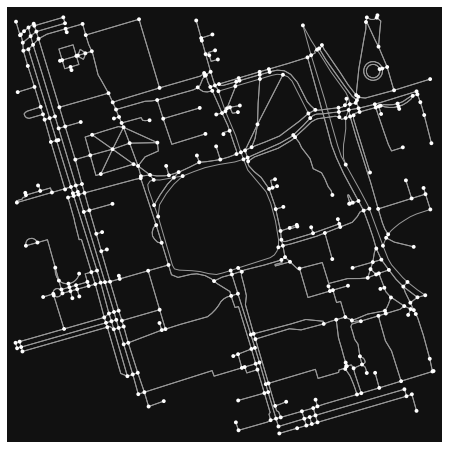

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [1]:
# Contraction Hierarchy

from sys import getsizeof
from time import process_time
import osmnx
import networkx as nx
from search_optimization_tools.routing import cost, draw_route
from search_optimization_tools.structures import Node, Solution

osmnx.utils.config(requests_kwargs={"verify": False})
reference = (43.661667, -79.395)
G = osmnx.graph_from_point(reference, dist=300, clean_periphery=True, simplify=True)

origin = Node(G, 55808290)
destination = Node(G, 389677909)
osmnx.plot_graph(G)


In [2]:
# Step 1: Remove Parallels and Loops, because Dijkstra doesn't like that
clean_G = G.copy()
clean_G.clear_edges()
for u in G.nodes:
    for v in G[u]:
        if u == v: continue # Remove self loops
        if len(G[u][v]) > 1:
            keep = min(G[u][v], key=lambda x:G[u][v][x]['length'])
            keep = G[u][v][keep]
            clean_G.add_edge(u,v,**keep)
            continue
        clean_G.add_edge(u,v,**G[u][v][0])

print(G)
orig_G = G.copy()
G = clean_G
print(G)

MultiDiGraph with 404 nodes and 1094 edges
MultiDiGraph with 404 nodes and 1072 edges


In [3]:
def edge_differences(G, sp):
    edge_difference = {}
    degrees = dict(G.degree)
    for node in G.nodes:
        req_edges = 0
        neighbours = list(G.neighbors(node))

        # Some nodes are deadends. The ED for these nodes is just the degree.
        if len(neighbours)==0: edge_difference[node] = - degrees[node]

        for u, v in G.in_edges(node):
            for v, w in G.out_edges(node):
                if u == w: continue # Two way edge, ignore this
                if v in sp[u][w]:
                    req_edges += 1
        
        edge_difference[node] = req_edges - degrees[node]


    return dict(sorted(edge_difference.items(), key=lambda x: x, reverse=True))
    

In [4]:
# Using functions from smart_mobility_utilities, we can generate shortest paths and edge differences very quickly

sp = dict(nx.all_pairs_dijkstra_path(G, weight="length"))
ed = edge_differences(G,sp)
hierarchical_order = {node: order for order, node in enumerate(ed)}

In [5]:
from tqdm.notebook import tqdm
def contract_graph(G, ed, cost_fn):
    contracted = 0
    start_time = process_time()
    space_required = 0
    for node in tqdm(list(ed.keys())[::-1]):
        sp = dict(nx.all_pairs_dijkstra_path(G, weight="length"))
        space_required = max(space_required, getsizeof(sp))
        current_G = G.copy()
        current_G.remove_node(node)

        for u, v in G.in_edges(node):
            for v, w in G.out_edges(node):
                if u == w: continue # Two way edge, ignore this
                if v in sp[u][w]:
                    G.add_edge(u,w, length=cost_fn(G, sp[u][w]), midpoint=v)
                    contracted += 1

    end_time = process_time()
    return Solution(G, end_time-start_time, space_required, contracted)


In [6]:
preprocess_sln = contract_graph(G, ed, cost)
G = preprocess_sln.result
print(f"Preprocessing time: {preprocess_sln.time} s")
print(f"Preprocessing Space: {preprocess_sln.space} bytes")
print(f"Shortcut edges added Explored: {preprocess_sln.explored}")

  0%|          | 0/404 [00:00<?, ?it/s]

21631731
[21631731]
[389677893] 389678033


IndexError: list index out of range

In [ ]:
osmnx.io.save_graphml(G)

In [ ]:
origin = Node(G, 55808290)
destination = Node(G, 389677909)

In [ ]:
import math
def Bidirectional_Dijkstra(G, origin, destination, hierarchy):
    start_time = process_time()
    direction = True
    frontier_f = {n: Node(G, n) for n in G.nodes}
    frontier_b = {n: Node(G, n) for n in G.nodes}
    
    sp_f = {id: math.inf for id in G.nodes}
    sp_b = {id: math.inf for id in G.nodes}
    space_required = getsizeof(frontier_b) + getsizeof(frontier_f) + getsizeof(sp_f) + getsizeof(sp_b)
    explored_f = set()
    explored_b = set()
    sp_f[origin.get_id()] = 0
    sp_b[destination.get_id()] = 0
    mu = math.inf
    saved_route = []

    while frontier_f and frontier_b:
        if direction:
            # Forwards search
            id, node = min(frontier_f.items(), key=lambda x: sp_f[x[0]])
            frontier_f.pop(id) # remove from frontier
            explored_f.add(node)
            out_edges = sorted(G.out_edges(id), key=lambda x: hierarchy[x[1]])
            for u,v in out_edges:
                # We only consider hierarchy < current
                if hierarchy[v] > hierarchy[u]: continue
                if v in explored_b:
                    # We hit a overlap
                    total_distance = sp_f[id] + G[u][v][0]["length"] + sp_b[v]
                    if total_distance < mu:
                        mu = total_distance
                        overlap = next(n for n in explored_b if v == n.get_id())
                        saved_route = node.path() + overlap.path()[::-1]
                    else:
                        space_required += getsizeof(explored_b) + getsizeof(explored_f)
                        end_time = process_time()
                        return Solution(saved_route, end_time-start_time, space_required, len(explored_b) + len(explored_f)) 
                    
                child = frontier_f[v]
                child.parent = node
                explored_f.add(child)
                sp_f[v] = sp_f[node] + G[u][v][0]["length"]
                child.distance = G[u][v][0]["length"]
                frontier_f[child.get_id()] = child
            direction = False
            continue
        if not direction:
            # Backwards search
            id, node = min(frontier_b.items(), key=lambda x: sp_b[x[0]])
            frontier_b.pop(id) # remove from frontier
            explored_b.add(node)
            in_edges = sorted(G.in_edges(id), key=lambda x: hierarchy[x[1]], reverse=True)
            for u,v in in_edges:
                # We only consider hierarchy > current
                if hierarchy[u] > hierarchy[v]: continue
                if u in explored_f:
                    # We hit a overlap
                    total_distance = sp_b[id] + G[u][v][0]["length"] + sp_f[u]
                    if total_distance < mu:
                        mu = total_distance
                        overlap = next(n for n in explored_f if u == n.get_id())
                        saved_route = overlap.path() + node.path()[::-1] 
                    else:
                        space_required += getsizeof(explored_b) + getsizeof(explored_f)
                        end_time = process_time()
                        return Solution(saved_route, end_time-start_time, space_required, len(explored_b) + len(explored_f)) 
                child = frontier_b[u]
                child.parent = node
                explored_b.add(child)
                sp_b[u] = sp_b[node] + G[u][v][0]["length"]
                child.distance = G[u][v][0]["length"]
                frontier_b[child.get_id()] = child
            direction = True

In [ ]:
nx.dijkstra_path_length(orig_G, origin.osmid, destination.osmid, weight="length")

In [ ]:
solution = Bidirectional_Dijkstra(G, origin, destination, hierarchical_order)
print(f"Process Time: {solution.time}")
print(f"Space Req: {solution.space}")
print(f"Explored nodes: {solution.explored}")

In [ ]:
def unpack(G, u,v):
    if "midpoint" in G[u][v][0]:
        midpoint = G[u][v][0]["midpoint"]
        return unpack(G,u,midpoint) + unpack(G,midpoint, v)
    return [u]

In [ ]:
route = []
for u,v in zip(solution.result[:-1], solution.result[1:]):
    route.extend(unpack(G,u,v))
route += [solution.result[-1]]
print(route)

In [ ]:
cost(G, route)

In [ ]:
draw_route(G, route)